In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import torch

train_on_gpu = torch.cuda.is_available() # if cuda is available than training on GPU else on CPU 

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip # unzip data

In [4]:
import pickle # For work with images
import random
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# in sklearn we have some problems with inserting images to colab
# we will ignore warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [5]:
SEED = 1937

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


In [6]:
# List with modes of datasets 
DATA_MODES = ['train', 'val', 'test']
# settting rescaling size of image to 224x224
RESCALE_SIZE = 224
# setting GPU device
DEVICE = torch.device("cuda")

In [7]:
class SimpsonsDataset(Dataset):
    """
    Dataset that will take images from dirs and augmentate them
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # to convert images to PyTorch tensors and normalize the input
        if self.mode == 'train': 
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [8]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [9]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))


In [10]:
def create_dct_from_labels(train_val_labels):
    """The function creates a dict dictionary from the list train_val_labels, which contains class labels
       corresponding to images from the selection, with keys corresponding
       to class names, and values corresponding to the number of these classes in
       the list train_val_labels"""
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

In [11]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files] # классы train + val
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [12]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [13]:
def create_dct_path_labels(train_files, train_labels):
    """The function creates a dictionary in which the key is the name of the character, and 
       the value is the path where you can find images with this character
    """
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

# Creating dictionary with pathes to images
dct_path_train = create_dct_path_labels(train_files, train_labels)

# Checking result
print_dct(dct_path_train)


# If images of some class < 100 than fill this class with copies
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

# Checking number of images for all classes
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files] # классы train

# выведим на печать класс:количесвто картинок для train должно быть примерно 75 %
print_dct(create_dct_from_labels(new_train_label))

abraham_grampa_simpson	[PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0123.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0342.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0549.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0551.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0698.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0263.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0741.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0592.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0429.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0130.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0220.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0548.jpg'), PosixPath('train/simpsons_dataset/abraham_grampa_simpson/pic_0052.jpg'), PosixPath('train/simpsons_d

In [14]:
val_dataset = SimpsonsDataset(val_files, mode='val') # Creating validation dataset
new_train_dataset = SimpsonsDataset(new_train_files, mode='train') # Creating train dataset

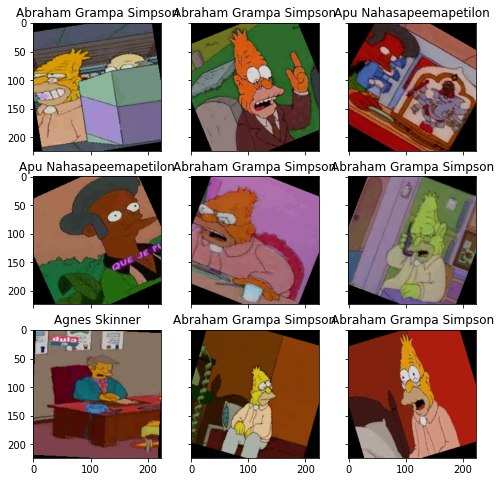

In [15]:
# Showing random 9 images
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = new_train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### **Как мы видим, данные для обучения сети будут поставляться с аугментациями**

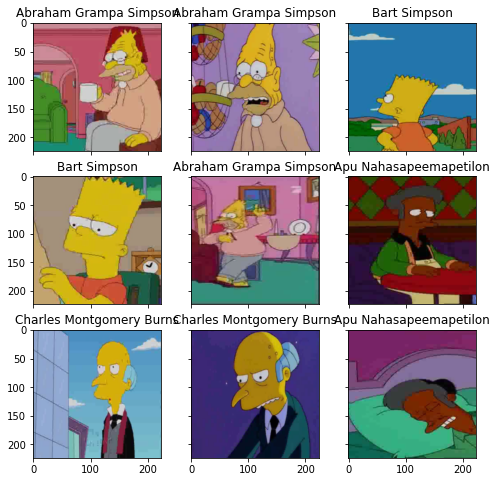

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [17]:
def fit_epoch(model, train_loader, criterion, optimizer):
    """This function will represent 1 epoch of fitting"""
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE) # For calculating on GPU
        labels = labels.to(DEVICE) # For calculating on GPU
        optimizer.zero_grad() # reset to zero old gradients of optimizer

        outputs = model(inputs) # calculating model outputs 
        loss = criterion(outputs, labels) # Finding loss of our model
        loss.backward() # Making gradient descent by our graph of calculating
        optimizer.step() # making step of our optimizer
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [18]:
def eval_epoch(model, val_loader, criterion):
    """This function will represent 1 evaluation epoch"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False): # We do not need to calculate gradients and just set gradients calculating to False
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [45]:
def train(train_dataset, val_dataset, model, epochs, batch_size, shuffle=True, sampler=None):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler, num_workers=4) # Making loader for train with shuffling
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Making loader for validation without shuffling

    history = [] # List with history of accuary
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.SGD(model.parameters(), lr= 1e-3) # casual optimizer
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min') # Casual scheduler
        criterion = nn.CrossEntropyLoss() 

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step(val_loss)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [20]:
def predict(model, test_loader):
    """Function will predict probabilities of accessories image to all classes"""
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [21]:
n_classes = len(np.unique(train_val_labels))

In [22]:
from torchvision import models

In [46]:
model = models.resnet50(pretrained=True).to(DEVICE) # using pretrained neural network resnet50

In [47]:
model.fc = nn.Sequential(nn.Linear(2048,n_classes)) # changing last layer on layer that will aproach to our task 

In [48]:
model = model.cuda()

Запустим обучение сети.

In [26]:
import copy

# saving weights of our model
model_pre_weights = copy.deepcopy(model.state_dict())
torch.save(model_pre_weights, "path_to\\model_pre_weights.pth")

In [49]:
history = train(new_train_dataset, val_dataset, model=model, epochs=30, batch_size=32) # training

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 3.202806907971606


epoch:   3%|▎         | 1/30 [04:51<2:20:49, 291.35s/it]


Epoch 001 train_loss: 3.2028     val_loss 2.8237 train_acc 0.1556 val_acc 0.2484
loss 1.3772894158416966


epoch:   7%|▋         | 2/30 [09:34<2:14:49, 288.93s/it]


Epoch 002 train_loss: 1.3773     val_loss 0.4957 train_acc 0.6697 val_acc 0.8686
loss 0.483812969885976


epoch:  10%|█         | 3/30 [14:17<2:09:15, 287.25s/it]


Epoch 003 train_loss: 0.4838     val_loss 0.2972 train_acc 0.8703 val_acc 0.9226
loss 0.3225191056728363


epoch:  13%|█▎        | 4/30 [19:01<2:03:58, 286.11s/it]


Epoch 004 train_loss: 0.3225     val_loss 0.2929 train_acc 0.9154 val_acc 0.9228
loss 0.24555721031416447


epoch:  17%|█▋        | 5/30 [23:46<1:59:02, 285.69s/it]


Epoch 005 train_loss: 0.2456     val_loss 0.2186 train_acc 0.9327 val_acc 0.9440
loss 0.19637021674016905


epoch:  20%|██        | 6/30 [28:28<1:53:54, 284.77s/it]


Epoch 006 train_loss: 0.1964     val_loss 0.2197 train_acc 0.9472 val_acc 0.9413
loss 0.15974678503810813


epoch:  23%|██▎       | 7/30 [33:12<1:49:01, 284.42s/it]


Epoch 007 train_loss: 0.1597     val_loss 0.2055 train_acc 0.9560 val_acc 0.9505
loss 0.13511288281255623


epoch:  27%|██▋       | 8/30 [37:56<1:44:16, 284.37s/it]


Epoch 008 train_loss: 0.1351     val_loss 0.1802 train_acc 0.9626 val_acc 0.9597
loss 0.11860051906675091


epoch:  30%|███       | 9/30 [42:40<1:39:29, 284.24s/it]


Epoch 009 train_loss: 0.1186     val_loss 0.1721 train_acc 0.9673 val_acc 0.9587
loss 0.10541756545667837


epoch:  33%|███▎      | 10/30 [47:24<1:34:40, 284.03s/it]


Epoch 010 train_loss: 0.1054     val_loss 0.1866 train_acc 0.9709 val_acc 0.9568
loss 0.09124726190568824


epoch:  37%|███▋      | 11/30 [52:07<1:29:54, 283.93s/it]


Epoch 011 train_loss: 0.0912     val_loss 0.2135 train_acc 0.9747 val_acc 0.9501
loss 0.07816380739287004


epoch:  40%|████      | 12/30 [56:51<1:25:07, 283.76s/it]


Epoch 012 train_loss: 0.0782     val_loss 0.1727 train_acc 0.9786 val_acc 0.9587
loss 0.06741542926278118


epoch:  43%|████▎     | 13/30 [1:01:34<1:20:22, 283.67s/it]


Epoch 013 train_loss: 0.0674     val_loss 0.1870 train_acc 0.9805 val_acc 0.9545
loss 0.0660598468034357


epoch:  47%|████▋     | 14/30 [1:06:17<1:15:33, 283.36s/it]


Epoch 014 train_loss: 0.0661     val_loss 0.1651 train_acc 0.9813 val_acc 0.9624
loss 0.06076127685778467


epoch:  50%|█████     | 15/30 [1:10:59<1:10:46, 283.13s/it]


Epoch 015 train_loss: 0.0608     val_loss 0.1497 train_acc 0.9838 val_acc 0.9675
loss 0.04945356474878428


epoch:  53%|█████▎    | 16/30 [1:15:44<1:06:11, 283.70s/it]


Epoch 016 train_loss: 0.0495     val_loss 0.1883 train_acc 0.9868 val_acc 0.9610
loss 0.04521430882989239


epoch:  57%|█████▋    | 17/30 [1:20:29<1:01:31, 284.00s/it]


Epoch 017 train_loss: 0.0452     val_loss 0.1729 train_acc 0.9876 val_acc 0.9656
loss 0.037960278287366776


epoch:  60%|██████    | 18/30 [1:25:14<56:52, 284.35s/it]


Epoch 018 train_loss: 0.0380     val_loss 0.1653 train_acc 0.9890 val_acc 0.9654
loss 0.03738903980131627


epoch:  63%|██████▎   | 19/30 [1:29:59<52:10, 284.59s/it]


Epoch 019 train_loss: 0.0374     val_loss 0.1803 train_acc 0.9884 val_acc 0.9635
loss 0.036626626234463014


epoch:  67%|██████▋   | 20/30 [1:34:44<47:25, 284.53s/it]


Epoch 020 train_loss: 0.0366     val_loss 0.1689 train_acc 0.9906 val_acc 0.9652
loss 0.03417348666973087


epoch:  70%|███████   | 21/30 [1:39:28<42:40, 284.52s/it]


Epoch 021 train_loss: 0.0342     val_loss 0.1668 train_acc 0.9898 val_acc 0.9673
loss 0.03000736542323896


epoch:  73%|███████▎  | 22/30 [1:44:13<37:57, 284.72s/it]


Epoch 022 train_loss: 0.0300     val_loss 0.1992 train_acc 0.9915 val_acc 0.9618
loss 0.031111524673178792


epoch:  77%|███████▋  | 23/30 [1:48:59<33:14, 284.87s/it]


Epoch 023 train_loss: 0.0311     val_loss 0.1875 train_acc 0.9908 val_acc 0.9624
loss 0.023645358542653244


epoch:  80%|████████  | 24/30 [1:53:42<28:26, 284.48s/it]


Epoch 024 train_loss: 0.0236     val_loss 0.1732 train_acc 0.9931 val_acc 0.9696
loss 0.023094435002005427


epoch:  83%|████████▎ | 25/30 [1:58:26<23:41, 284.24s/it]


Epoch 025 train_loss: 0.0231     val_loss 0.1798 train_acc 0.9935 val_acc 0.9681
loss 0.023014271953507


epoch:  87%|████████▋ | 26/30 [2:03:10<18:56, 284.24s/it]


Epoch 026 train_loss: 0.0230     val_loss 0.1743 train_acc 0.9933 val_acc 0.9702
loss 0.011551974996155142


epoch:  90%|█████████ | 27/30 [2:07:54<14:12, 284.08s/it]


Epoch 027 train_loss: 0.0116     val_loss 0.1588 train_acc 0.9971 val_acc 0.9719
loss 0.009846203374649809


epoch:  93%|█████████▎| 28/30 [2:12:38<09:28, 284.18s/it]


Epoch 028 train_loss: 0.0098     val_loss 0.1594 train_acc 0.9972 val_acc 0.9715
loss 0.008302920596181687


epoch:  97%|█████████▋| 29/30 [2:17:22<04:44, 284.16s/it]


Epoch 029 train_loss: 0.0083     val_loss 0.1585 train_acc 0.9979 val_acc 0.9721
loss 0.009529874623058841


epoch: 100%|██████████| 30/30 [2:22:07<00:00, 284.24s/it]


Epoch 030 train_loss: 0.0095     val_loss 0.1603 train_acc 0.9969 val_acc 0.9723


In [50]:
import os
os.listdir()

['.config',
 'sample_submission.csv',
 'testset',
 'path_to\\model_pre_weights.pth',
 'label_encoder.pkl',
 'gdrive',
 'characters_illustration.png',
 'train',
 'sample_data']

In [51]:
# saving weights after training
model_30epoch_weights = copy.deepcopy(model.state_dict())

torch.save(model_30epoch_weights, "gdrive/My Drive/model_resnet50_60epoch_32batchsize_scheduller_reduceltonplateau_weights.pth")

Построим кривые обучения

In [52]:
loss, acc, val_loss, val_acc = zip(*history)

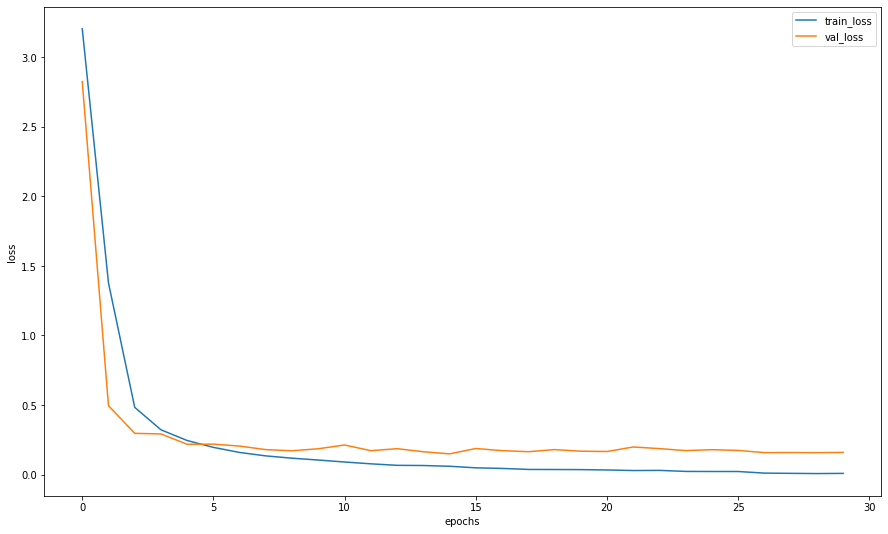

In [53]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [33]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Predictions for 1 image"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [59]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [60]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [61]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [62]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Так как целевая метрика является f1-score, проверим, какой скор она выдаст


In [64]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')

1.0

Сделаем классную визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах.


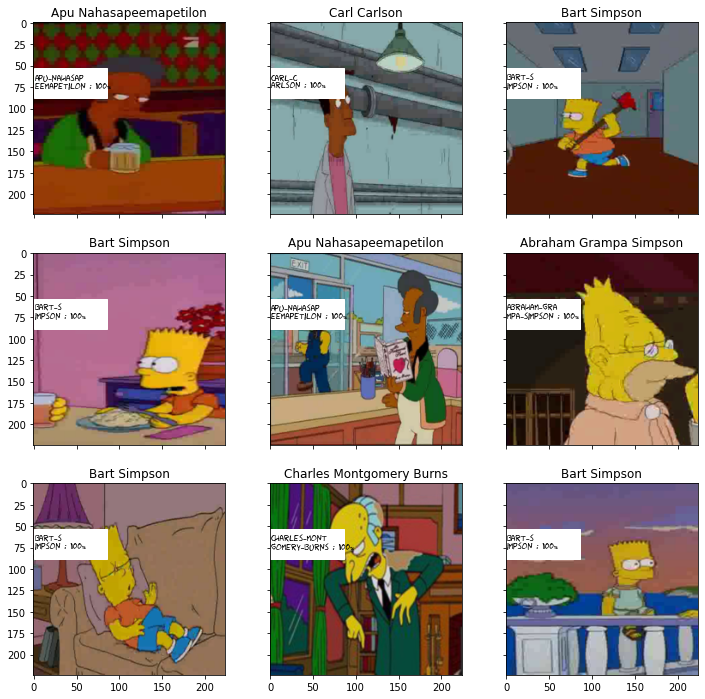

In [65]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# **Submit на Kaggle**

In [66]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
! ls 

 characters_illustration.png  'path_to\model_pre_weights.pth'   testset
 gdrive			       sample_data		        train
 label_encoder.pkl	       sample_submission.csv


In [67]:
import pandas as pd
mysubmit = pd.DataFrame(columns=['Id'])
test_filenames = [path.name for path in test_dataset.files]
mysubmit['Id'] = test_filenames

In [68]:
mysubmit[f'Expected'] = preds

In [69]:
mysubmit.to_csv('gdrive/My Drive/4.csv', index=False)